<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/PTB_XL_5MI_classes_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI and CDs detection using PTB-XL with 1-leads and 5-fold CV




## STEP 1: Install necessary packages



In [1]:
# Multi-branch Fusion Network for Myocardial Infarction Detection on PTB-XL
# Google Colab Version - Adapted from the original paper
# Binary Classification: MI vs Non-MI

# Install required packages
!pip install wfdb requests tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 142.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


## STEP 2: Read database

In [2]:
# Multi-branch Fusion Network for Myocardial Infarction Detection on PTB-XL
# Google Colab Version - Adapted from the original paper
# Binary Classification: MI vs Non-MI

# Install required packages
!pip install wfdb requests tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import wfdb
import os
import ast
import requests
import zipfile
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


## STEP 3: Load metadata and diagnostic class mapping

In [ ]:
def load_ptbxl_metadata(path):
    data = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'))
    data.scp_codes = data.scp_codes.apply(lambda x: ast.literal_eval(x))
    return data

# Load SCP statements
def load_diagnostic_class_mapping(path):
    return pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)

## STEP 4: Apply MI vs Non-MI filter

In [ ]:
def apply_diagnostic_filter_5class(data, class_map):
    # Step 1: Map SCP codes to diagnostic classes
    data['diagnostic_class'] = data.scp_codes.apply(
        lambda x: list(set([class_map.loc[k].diagnostic_class for k in x if k in class_map.index]))
    )

    # Step 2: Assign a single label per record based on priority
    priority_list = ['MI', 'STTC', 'CD', 'HYP', 'NORM']
    def assign_label(class_list):
        for cls in priority_list:
            if cls in class_list:
                return cls
        return 'Other'

    data['diagnostic_label'] = data.diagnostic_class.apply(assign_label)

    return data



## STEP 5: Load ECG signals

In [ ]:
def load_raw_data(df, sampling_rate, path):
    data = []
    for i in range(len(df)):
        record_name = df.iloc[i].filename_lr if sampling_rate == 100 else df.iloc[i].filename_hr
        record_path = os.path.join(path, record_name)
        signal, _ = wfdb.rdsamp(record_path)
        data.append(signal)
    return np.array(data)

In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avvarusrinivasulu","key":"fe47c5051ef67f1130ff6e2e1fa439be"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

## STEP 7: Main pipeline

In [5]:
import os, ast, wfdb, requests, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

np.random.seed(42)
tf.random.set_seed(42)


class PTBXLDataLoader:
    """Data loader for PTB-XL database - Multi-class MI classification"""

    def __init__(self, data_path='/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'):
        self.data_path = data_path
        self.sampling_rate = 100
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        # Define MI subtypes
        # self.mi_classes = ['IMI', 'ASMI', 'ILMI', 'AMI', 'LMI', 'IPLMI', 'IPMI', 'PMI', 'ALMI']
        self.mi_classes = ['IMI', 'ASMI', 'AMI', 'IPMI']
        self.label_map = {mi_type: i for i, mi_type in enumerate(self.mi_classes)}
        self.label_map['Other'] = len(self.mi_classes)  # 'Other' class index


    def load_metadata(self):
        """Load PTB-XL metadata and extract MI subtype labels"""
        try:
            df = pd.read_csv(os.path.join(self.data_path, 'ptbxl_database.csv'))

            # Parse SCP codes safely
            def parse_scp_codes(scp_string):
                try:
                    return ast.literal_eval(scp_string) if pd.notna(scp_string) else {}
                except:
                    return {}

            df['scp_codes_parsed'] = df.scp_codes.apply(parse_scp_codes)

            # Assign MI subtype label
            def get_mi_label(scp_dict):
                if not isinstance(scp_dict, dict):
                    return 'Other'
                for mi_code in self.mi_classes:
                    if mi_code in scp_dict:
                        return mi_code
                return 'Other'

            df['mi_type'] = df['scp_codes_parsed'].apply(get_mi_label)

            # Filter for 100 Hz sampling
            # df = df[df.sampling_rate == 100].copy()

            print(f"Dataset Summary:")
            print(df['mi_type'].value_counts())

            return df

        except FileNotFoundError as e:
            print(f"Error loading metadata: {e}")
            return None


    def load_signal(self, filename_lr):
        """Load a single ECG record"""
        try:
            record_path = os.path.join(self.data_path, filename_lr).replace('.dat', '')
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal[:, [1, 7, 8]]  # 3 selected leads
            return signal
        except Exception as e:
            return None


    def prepare_dataset(self, max_samples_per_class=700, min_length=1000):
        """Prepare dataset for multi-class MI classification"""
        df = self.load_metadata()
        if df is None:
            return None, None, None

        # Group by class
        grouped = df.groupby('mi_type')
        class_counts = grouped.size()
        print("\nBefore balancing:")
        print(class_counts)

        # Balance all classes (including 'Other')
        balanced_dfs = []
        for label, group in grouped:
            n_samples = min(max_samples_per_class, len(group))
            balanced_dfs.append(group.sample(n_samples, random_state=42))

        balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

        print("\nAfter balancing:")
        print(balanced_df['mi_type'].value_counts())

        signals, labels = [], []
        failed = 0

        print("\nLoading ECG signals...")
        for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
            signal = self.load_signal(row.filename_lr)
            if signal is not None and signal.shape[0] >= min_length:
                signals.append(signal)
                labels.append(self.label_map[row.mi_type])
            else:
                failed += 1

        if failed > 0:
            print(f"Failed to load {failed} signals")

        print(f"Successfully loaded {len(signals)} signals.")
        print(f"Final class distribution:")
        print(pd.Series(labels).value_counts().sort_index())

        return np.array(signals), np.array(labels), balanced_df


In [6]:
class MultiBranchFusionNetwork:
    """Multi-branch fusion network adapted for time-series ECG data"""

    def __init__(self, input_length=1000, num_leads=12):
        self.input_length = input_length
        self.num_leads = num_leads
        self.model = None
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    def create_shallow_branch(self, input_shape, lead_name):
        """Create shallow neural network branch (as per paper)"""
        inputs = keras.Input(shape=input_shape, name=f'{lead_name}_input')

        # First conv layer (3x3 -> 1D kernel size 3)
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name=f'{lead_name}_conv1')(inputs)
        x = layers.MaxPooling1D(pool_size=2, name=f'{lead_name}_pool1')(x)

        # Second conv layer
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name=f'{lead_name}_conv2')(x)
        x = layers.MaxPooling1D(pool_size=2, name=f'{lead_name}_pool2')(x)

        # Output 32 features per branch (as per paper)
        x = layers.GlobalAveragePooling1D(name=f'{lead_name}_global_avg_pool')(x)
        x = layers.Dense(32, activation='relu', name=f'{lead_name}_dense')(x)

        return keras.Model(inputs, x, name=f'{lead_name}_shallow_branch')

    def create_densenet_classifier(self, input_dim, n_classes=5):
        """Create DenseNet-like classifier for multi-class MI classification"""
        inputs = keras.Input(shape=(input_dim,))

        x = layers.Dense(192, activation='relu')(inputs)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(288, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(144, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(72, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        # Multi-class classification output
        outputs = layers.Dense(n_classes, activation='softmax', name='mi_multiclass_prediction')(x)

        return keras.Model(inputs, outputs, name='densenet_multiclass_classifier')


    def build_model(self, n_classes=5):
        """Build the complete multi-branch fusion network for multi-class output"""

        lead_inputs = []
        branch_outputs = []

        for i in range(self.num_leads):
            lead_input = keras.Input(shape=(self.input_length,), name=f'lead_{self.lead_names[i]}_input')
            lead_inputs.append(lead_input)
            reshaped = layers.Reshape((self.input_length, 1), name=f'lead_{self.lead_names[i]}_reshape')(lead_input)

            branch = self.create_shallow_branch((self.input_length, 1), self.lead_names[i])
            branch_output = branch(reshaped)
            branch_outputs.append(branch_output)

        fused_features = layers.Concatenate(axis=-1, name='feature_fusion')(branch_outputs)

        classifier = self.create_densenet_classifier(fused_features.shape[-1], n_classes=n_classes)
        final_output = classifier(fused_features)

        self.model = keras.Model(inputs=lead_inputs, outputs=final_output, name='MultiBranchFusionNetwork_MI_Multiclass')
        return self.model


    def compile_model(self, learning_rate=0.01):
        optimizer = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True)
        # optimizer = keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )


    def train(self, X_train, y_train, X_val, y_val, epochs=150, batch_size=16):
        """Train the model for multi-class classification"""

        X_train_list = [X_train[:, :, i] for i in range(self.num_leads)]
        X_val_list = [X_val[:, :, i] for i in range(self.num_leads)]

        # Compute class weights (optional)
        from sklearn.utils.class_weight import compute_class_weight
        classes = np.unique(np.argmax(y_train, axis=1))  # if one-hot encoded
        class_weights = compute_class_weight('balanced', classes=classes, y=np.argmax(y_train, axis=1))
        class_weight_dict = {i: w for i, w in enumerate(class_weights)}
        print(f"Using class weights: {class_weight_dict}")

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        ]

        history = self.model.fit(
            X_train_list, y_train,
            validation_data=(X_val_list, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            # class_weight=class_weight_dict,
            verbose=1
        )

        return history


    def predict(self, X_test):
        """Make predictions"""
        X_test_list = [X_test[:, :, i] for i in range(self.num_leads)]
        return self.model.predict(X_test_list)

    def evaluate(self, X_test, y_test):
        """Evaluate model with classification metrics"""
        import numpy as np
        from sklearn.metrics import classification_report, confusion_matrix

        # Split multilead input into branches
        X_test_list = [X_test[:, :, i] for i in range(self.num_leads)]

        # Model prediction probabilities
        y_pred_proba = self.model.predict(X_test_list)

        # Convert probabilities to class predictions
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Handle label format (integer or one-hot)
        if y_test.ndim > 1:
            y_true = np.argmax(y_test, axis=1)
        else:
            y_true = y_test

        print("Classification Report:")
        print(classification_report(y_true, y_pred, digits=3))

        cm = confusion_matrix(y_true, y_pred)
        return cm, y_pred, y_pred_proba




In [7]:
def preprocess_signals(signals, target_length=1000):
    """Preprocess ECG signals to fixed length"""
    processed_signals = []

    print(f"Preprocessing signals to length {target_length}...")

    for signal in tqdm(signals):
        if signal.shape[0] > target_length:
            # Take middle portion (most stable part)
            start_idx = (signal.shape[0] - target_length) // 2
            signal = signal[start_idx:start_idx + target_length]
        elif signal.shape[0] < target_length:
            # Pad with last value
            padding = target_length - signal.shape[0]
            last_values = signal[-1:].repeat(padding, axis=0)
            signal = np.vstack([signal, last_values])

        processed_signals.append(signal)

    return np.array(processed_signals)

In [8]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [9]:
def plot_sample_ecg(signals, labels, idx=0):
    """Plot sample 12-lead ECG"""
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Time axis (assuming 100Hz sampling)
    time_axis = np.arange(signals[idx].shape[0]) / 100  # Convert to seconds

    for i, ax in enumerate(axes.flat):
        if i < 1:
            ax.plot(time_axis, signals[idx, :, i], linewidth=1.5, color='blue')
            ax.set_title(f'Lead {lead_names[i]}', fontsize=12)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Amplitude (mV)')
            ax.grid(True, alpha=0.3)

    label_text = "MI (Myocardial Infarction)" if labels[idx] else "Non-MI (Normal)"
    fig.suptitle(f'12-Lead ECG - {label_text}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [10]:
def print_results_table(metrics):
    """Print results in paper format"""
    print("\n" + "="*60)
    print("PERFORMANCE RESULTS (Paper Format)")
    print("="*60)
    print(f"{'Metric':<20} {'Value':<15} {'Percentage':<15}")
    print("-" * 60)
    print(f"{'Accuracy':<20} {metrics['accuracy']:<15.4f} {metrics['accuracy']*100:<15.2f}%")
    print(f"{'Sensitivity':<20} {metrics['sensitivity']:<15.4f} {metrics['sensitivity']*100:<15.2f}%")
    print(f"{'Specificity':<20} {metrics['specificity']:<15.4f} {metrics['specificity']*100:<15.2f}%")
    print(f"{'Precision':<20} {metrics['precision']:<15.4f} {metrics['precision']*100:<15.2f}%")
    print(f"{'F1-score':<20} {metrics['f1_score']:<15.4f} {metrics['f1_score']*100:<15.2f}%")
    print("="*60)

In [15]:
def main():
    """Main execution pipeline"""
    import numpy as np
    print("="*80)
    print("MULTI-BRANCH FUSION NETWORK FOR MI DETECTION - GOOGLE COLAB")
    print("Paper: Multi-branch fusion network for Myocardial infarction screening")
    print("Database: PTB-XL (PhysioNet)")
    print("Task: Binary Classification (MI vs Non-MI)")
    print("="*80)

    # Step 1: Download and load data
    print("\nSTEP 1: Loading PTB-XL Database...")
    data_loader = PTBXLDataLoader()

    # Download dataset
    # data_loader.download_ptbxl()

    # Load dataset
    signals, labels, df = data_loader.prepare_dataset(max_samples_per_class=5000)

    if signals is None or len(signals) == 0:
        print("No signals loaded. Please check dataset integrity.")
        return None, None, None

    print(f"\nDataset loaded successfully!")
    print(f"  Signal shape: {signals[0].shape} (time_steps, leads)")
    print(f"  Total samples: {len(signals)}")
    # print(f"  MI cases: {np.sum(labels)} ({np.mean(labels)*100:.1f}%)") # Not binary, so this print is wrong

    print(f"  Label distribution: {pd.Series(labels).value_counts().sort_index()}")

    # Step 2: Preprocess signals
    print(f"\nSTEP 2: Preprocessing Signals...")
    signals = preprocess_signals(signals, target_length=1000)

    # Normalize signals
    print("Normalizing signals...")
    signals_normalized = np.zeros_like(signals)

    import joblib

    scalers = []
    for lead_idx in range(signals.shape[2]):
        lead_data = signals[:, :, lead_idx]
        scaler = StandardScaler().fit(lead_data)
        signals_normalized[:, :, lead_idx] = scaler.transform(lead_data)
        scalers.append(scaler)

    joblib.dump(scalers, 'scalers.pkl')
    signals = signals_normalized
    print(f"Preprocessed signal shape: {signals.shape}")

    # Plot sample ECG
    # plot_sample_ecg(signals, labels, idx=0) # Plotting only 1 lead for now

    # Step 3: Split dataset
    print(f"\nSTEP 3: Splitting Dataset...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        signals, labels, test_size=0.4, random_state=42, stratify=labels
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"  Training: {X_train.shape[0]} samples")
    print(f"  Validation: {X_val.shape[0]} samples")
    print(f"  Test: {X_test.shape[0]} samples")

    from tensorflow.keras.utils import to_categorical

    # Convert labels (0–9 integers) to one-hot encoded vectors for model training
    y_train_one_hot = to_categorical(y_train, num_classes=5)
    y_val_one_hot   = to_categorical(y_val, num_classes=5)
    # y_test remains integer labels for evaluation metrics

    # Step 4: Build and train model
    print(f"\nSTEP 4: Building Multi-Branch Fusion Network...")
    n_classes = 5  # 4 MI types + Other
    model_builder = MultiBranchFusionNetwork(
        input_length=signals.shape[1],
        num_leads=signals.shape[2]
    )

    # Build model
    model = model_builder.build_model(n_classes=n_classes)
    model_builder.compile_model(learning_rate=0.001)

    print(f"\nModel Architecture:")
    model.summary()

    # Train model with class weights (recommended for imbalanced data)
    print(f"\nSTEP 5: Training Model with Class Balancing...")
    # Calculate class weights manually
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np

    # Ensure y_train is a 1D numpy array of integers
    y_train = np.asarray(y_train, dtype=int).flatten()

    # Compute class weights for the 1D integer labels (y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weights = dict(zip(np.unique(y_train), class_weights))
    print("Class Weights:", class_weights)


    history = model_builder.train(
        X_train, y_train_one_hot, # Use one-hot encoded for training
        X_val, y_val_one_hot,     # Use one-hot encoded for validation
        epochs=150,
        batch_size=32
    )

    # Plot training history
    plot_training_history(history)

    # Step 6: Evaluate model
    print(f"\nSTEP 6: Evaluating Model...")
    # Pass the original integer labels y_test to evaluate
    cm, y_pred, y_pred_proba = model_builder.evaluate(X_test, y_test)


    ###### Compute full metrics
    from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
    )
    import numpy as np

    # y_pred is already integer labels from np.argmax in model_builder.evaluate
    # y_test is already integer labels

    # Basic metrics (ensure same averaging / class choice)
    # Use 'macro' or 'weighted' average for multi-class metrics
    acc = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)


    metrics = {
        'accuracy': acc,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
    }

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    print("\nComputed metrics:")
    for k, v in metrics.items():
        print(f"{k:<20}: {v:.4f}")



    #### to calibrate threshold to achieve a target recall (e.g., 90%) — tuning threshold using precision_recall_curve:
    # This part is for binary classification and needs adjustment for multi-class
    # You would typically look at per-class precision-recall curves or use other multi-class techniques.
    # For simplicity, we'll skip this for now in the multi-class case.
    print("\nThreshold calibration skipped for multi-class evaluation.")


    # Print results (using weighted averages for overall summary)
    print("\n" + "="*60)
    print("PERFORMANCE RESULTS (Weighted Averages)")
    print("="*60)
    print(f"{'Metric':<20} {'Value':<15} {'Percentage':<15}")
    print("-" * 60)
    print(f"{'Accuracy':<20} {metrics['accuracy']:<15.4f} {metrics['accuracy']*100:<15.2f}%")
    print(f"{'Precision (Weighted)':<20} {metrics['precision_weighted']:<15.4f} {metrics['precision_weighted']*100:<15.2f}%")
    print(f"{'Recall (Weighted)':<20} {metrics['recall_weighted']:<15.4f} {metrics['recall_weighted']*100:<15.2f}%")
    print(f"{'F1-score (Weighted)':<20} {metrics['f1_weighted']:<15.4f} {metrics['f1_weighted']*100:<15.2f}%")
    # Specificity is not directly applicable or easily calculated in a simple way for multi-class
    print("="*60)


    # Compare with paper results (Note: Paper is binary MI vs Non-MI, this is multi-class)
    # Direct comparison is not meaningful here.
    print(f"\nCOMPARISON WITH PAPER RESULTS:")
    print("-" * 60)
    print("Note: Paper results are for binary MI vs Non-MI. This is multi-class MI subtype classification.")


    # Step 7: Save model to Google Drive
    print(f"\nSTEP 7: Saving Model to Google Drive...")
    # Ensure Google Drive is mounted if needed
    # from google.colab import drive
    # drive.mount('/content/drive')
    # model.save('/content/drive/MyDrive/mi_types_detection_model_multiclass_v1_0.h5')

    # Save results
    # results_df = pd.DataFrame([metrics])
    # results_df.to_csv('/content/drive/MyDrive/mi_types_detection_results_multiclass_v1_0.csv', index=False)

    print("Model and results saving skipped for now.")

    return model, metrics, history

MULTI-BRANCH FUSION NETWORK FOR MI DETECTION - GOOGLE COLAB
Paper: Multi-branch fusion network for Myocardial infarction screening
Database: PTB-XL (PhysioNet)
Task: Binary Classification (MI vs Non-MI)

STEP 1: Loading PTB-XL Database...
Dataset Summary:
mi_type
Other    17088
IMI       2685
ASMI      1774
AMI        260
IPMI        30
Name: count, dtype: int64

Before balancing:
mi_type
AMI        260
ASMI      1774
IMI       2685
IPMI        30
Other    17088
dtype: int64

After balancing:
mi_type
Other    5000
IMI      2685
ASMI     1774
AMI       260
IPMI       30
Name: count, dtype: int64

Loading ECG signals...


100%|██████████| 9749/9749 [00:24<00:00, 401.92it/s]


Successfully loaded 9749 signals.
Final class distribution:
0    2685
1    1774
2     260
3      30
4    5000
Name: count, dtype: int64

Dataset loaded successfully!
  Signal shape: (1000, 3) (time_steps, leads)
  Total samples: 9749
  Label distribution: 0    2685
1    1774
2     260
3      30
4    5000
Name: count, dtype: int64

STEP 2: Preprocessing Signals...
Preprocessing signals to length 1000...


100%|██████████| 9749/9749 [00:00<00:00, 1048576.00it/s]


Normalizing signals...
Preprocessed signal shape: (9749, 1000, 3)

STEP 3: Splitting Dataset...
  Training: 5849 samples
  Validation: 1950 samples
  Test: 1950 samples

STEP 4: Building Multi-Branch Fusion Network...

Model Architecture:


Model: "MultiBranchFusionNetwork_MI_Multiclass"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lead_I_input        │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_II_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_III_input      │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_I_reshape      │ (None, 1000, 1)   │          0 │ lead_I_input[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_II_reshape     │ (None, 1000, 1)   │          0 │ lead_II_input[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead_III_reshape    │ (None, 1000, 1)   │          0 │ lead_III_input[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ I_shallow_branch    │ (None, 32)        │      4,288 │ lead_I_reshape[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ II_shallow_branch   │ (None, 32)        │      4,288 │ lead_II_reshape[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ III_shallow_branch  │ (None, 32)        │      4,288 │ lead_III_reshape… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_fusion      │ (None, 96)        │          0 │ I_shallow_branch… │
│ (Concatenate)       │                   │            │ II_shallow_branc… │
│                     │                   │            │ III_shallow_bran… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet_multiclas… │ (None, 5)         │    126,629 │ feature_fusion[0… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 139,493 (544.89 KB)

 Trainable params: 139,493 (544.89 KB)

 Non-trainable params: 0 (0.00 B)


STEP 5: Training Model with Class Balancing...
Class Weights: {np.int64(0): np.float64(0.7261328367473618), np.int64(1): np.float64(1.099436090225564), np.int64(2): np.float64(7.498717948717949), np.int64(3): np.float64(64.9888888888889), np.int64(4): np.float64(0.38993333333333335)}
Using class weights: {0: np.float64(0.7261328367473618), 1: np.float64(1.099436090225564), 2: np.float64(7.498717948717949), 3: np.float64(64.9888888888889), 4: np.float64(0.38993333333333335)}
Epoch 1/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.4586 - loss: 1.3396 - val_accuracy: 0.5128 - val_loss: 1.1179 - learning_rate: 0.0050
Epoch 2/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5062 - loss: 1.1270 - val_accuracy: 0.5128 - val_loss: 1.0947 - learning_rate: 0.0050
Epoch 3/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5173 - loss: 1.1065 - val_accuracy: 0.5431 - val_loss: 1.0664 - learning_rate: 0.0050
Epoch 4/150
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - 

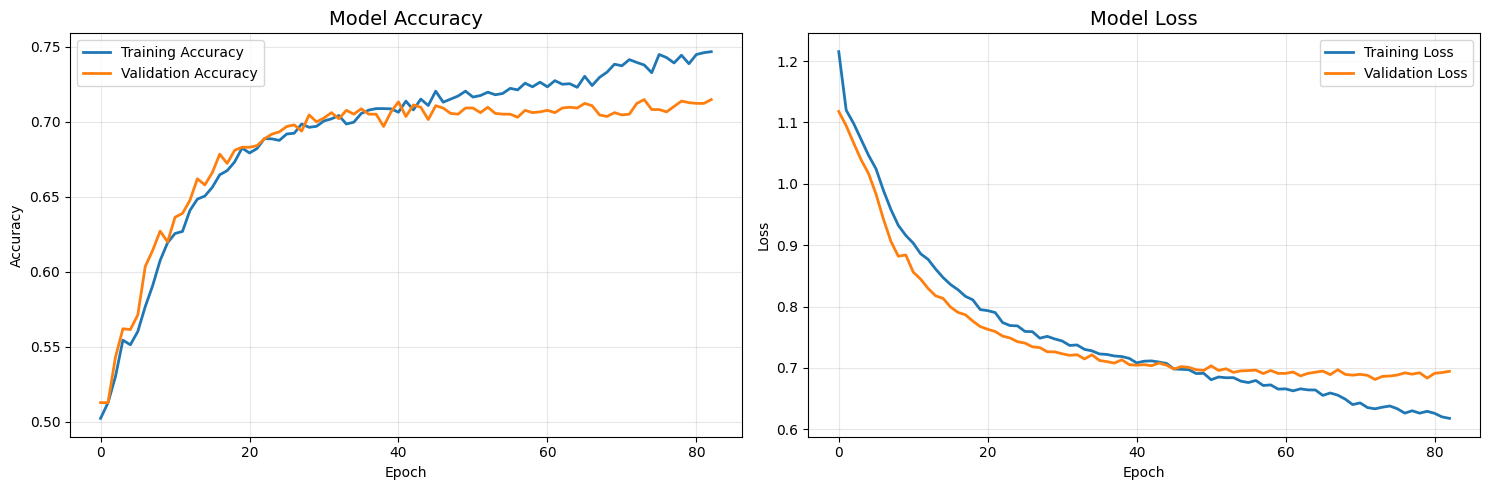


STEP 6: Evaluating Model...
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.656     0.575     0.613       537
           1      0.653     0.673     0.663       355
           2      0.368     0.135     0.197        52
           3      0.000     0.000     0.000         6
           4      0.784     0.858     0.819      1000

    accuracy                          0.725      1950
   macro avg      0.492     0.448     0.459      1950
weighted avg      0.712     0.725     0.715      1950


Confusion Matrix:
 [[309  72   1   0 155]
 [ 51 239   6   0  59]
 [  7  19   7   0  19]
 [  3   0   0   0   3]
 [101  36   5   0 858]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6561    0.5754    0.6131       537
           1     0.6530    0.6732    0.6630       355
           2     0.3684    0.1346    0.1972        52
           3     0.0000    0.0000    0.00

In [16]:
# Run the main pipeline
if __name__ == "__main__":
    model, metrics, history = main()

## STEP 6: Define ResNet-like model

## Model setup and Training

## Testing the Model